In [1]:
import tensorflow as tf
from tensorflow.keras.models import model_from_json, Model
import numpy as np
import matplotlib.pyplot as plt
import cv2


LOAD MODEL

In [2]:
with open('model/model_a1.json', 'r') as json_file:
    model_json = json_file.read()

In [8]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import Model

# Register 'Functional' to fix the 'Functional not found' error
get_custom_objects().update({'Functional': Model})

# Load the architecture
with open('model/model_a1.json', 'r') as json_file:
    model_json = json_file.read()

model = model_from_json(model_json)  

# Load the weights
model.load_weights('model/model_weights1.h5')  

print(" Model loaded successfully.")


 Model loaded successfully.


IMAGE LOADING AND PREPROCESSING

In [9]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1)  # For grayscale
    img = np.expand_dims(img, axis=0)
    return img

Visualize Activations for Specific Layer

In [13]:
def visualize_activations(model, img, layer_names=None):
    if layer_names is None:
        # Only pick Conv and Activation layers with 4D output
        layer_names = [
            layer.name for layer in model.layers
            if 'activation' in layer.name or 'conv' in layer.name
        ]

    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    activations = activation_model.predict(img)

    for layer_name, activation in zip(layer_names, activations):
        print(f"\n🔍 Visualizing layer: {layer_name}")
        
        # Only visualize 4D activation maps
        if len(activation.shape) != 4:
            print(f"⚠️ Skipping layer {layer_name} (shape: {activation.shape})")
            continue
        
        num_filters = activation.shape[-1]
        size = activation.shape[1]

        cols = 8
        rows = num_filters // cols
        if rows == 0: continue  # skip layers with very few filters

        display_grid = np.zeros((size * rows, size * cols))

        for i in range(rows):
            for j in range(cols):
                idx = i * cols + j
                if idx >= num_filters: break
                channel_image = activation[0, :, :, idx]
                channel_image -= channel_image.mean()
                channel_image /= (channel_image.std() + 1e-5)
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[i * size: (i + 1) * size,
                             j * size: (j + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.axis('off')
        plt.show()


FINAL OUTPUT

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

🔍 Visualizing layer: conv2d


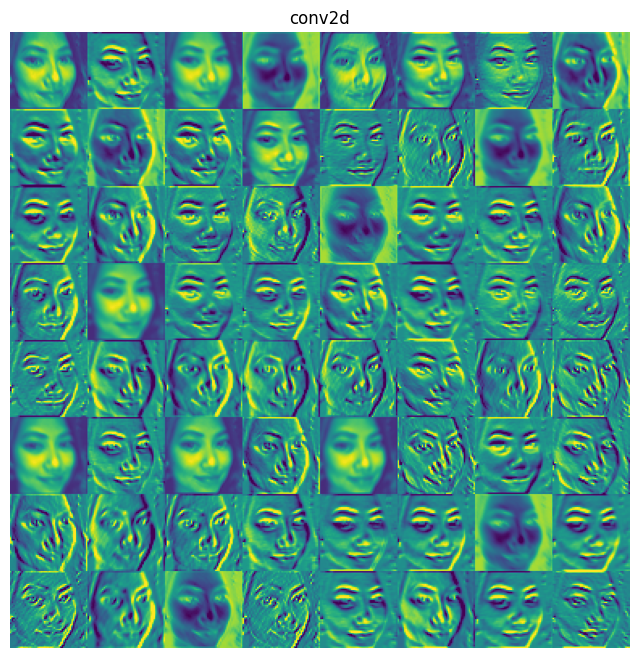


🔍 Visualizing layer: activation


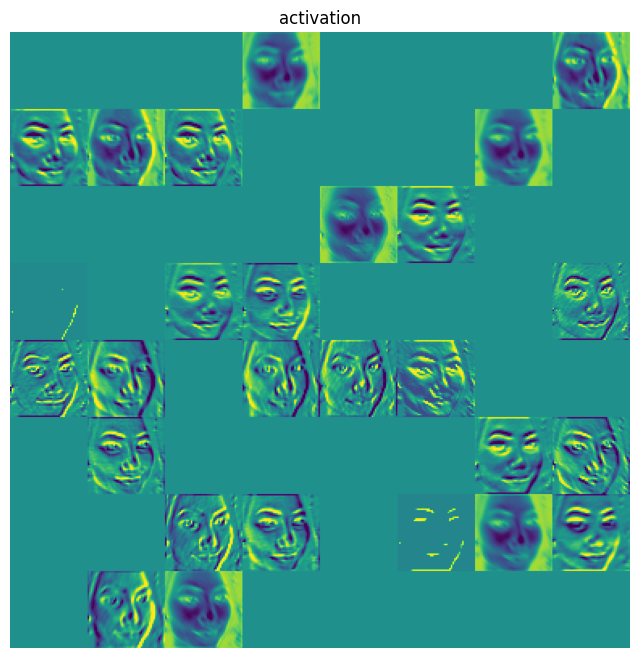


🔍 Visualizing layer: conv2d_1


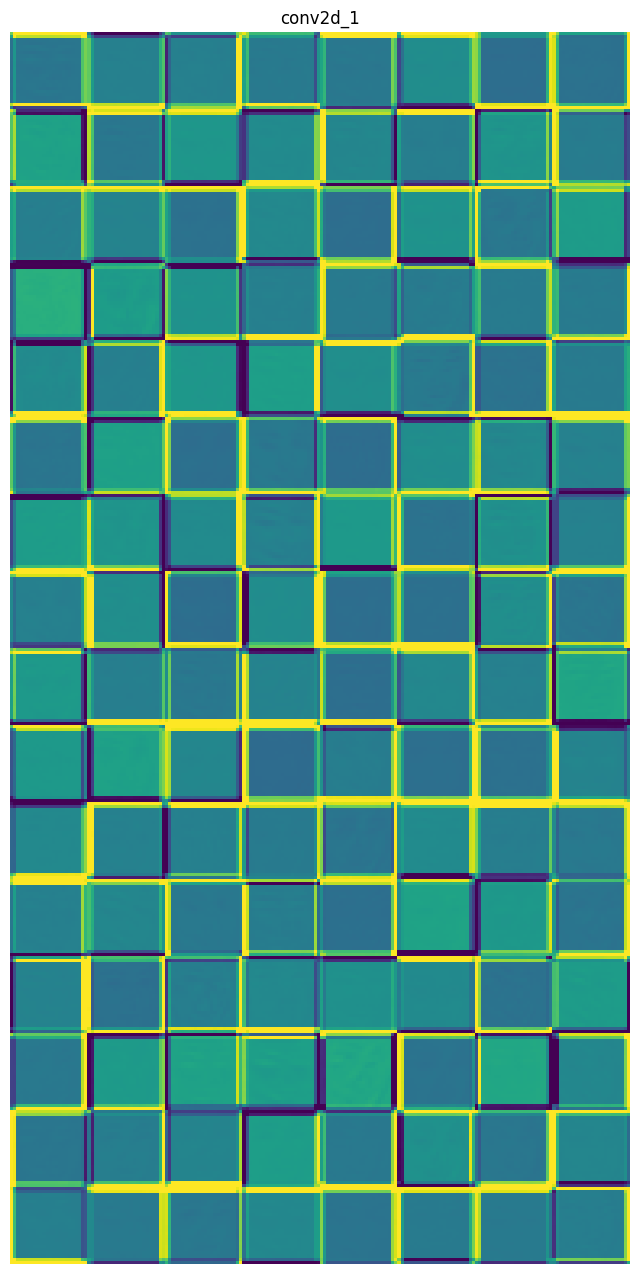


🔍 Visualizing layer: activation_1


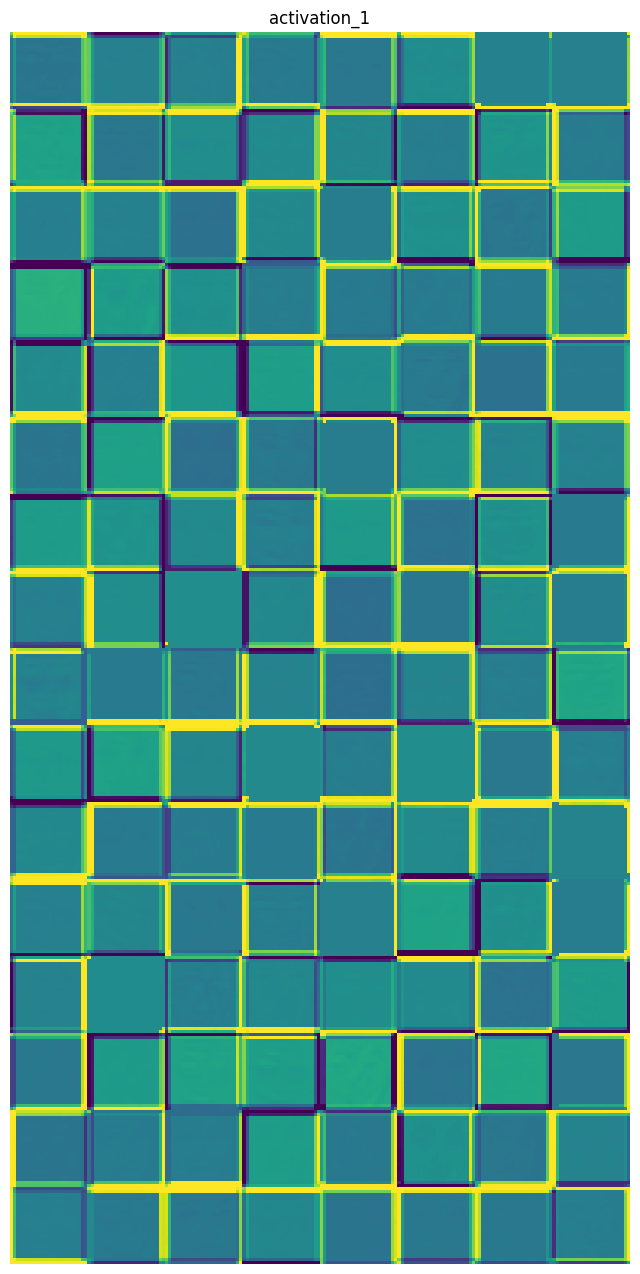


🔍 Visualizing layer: conv2d_2


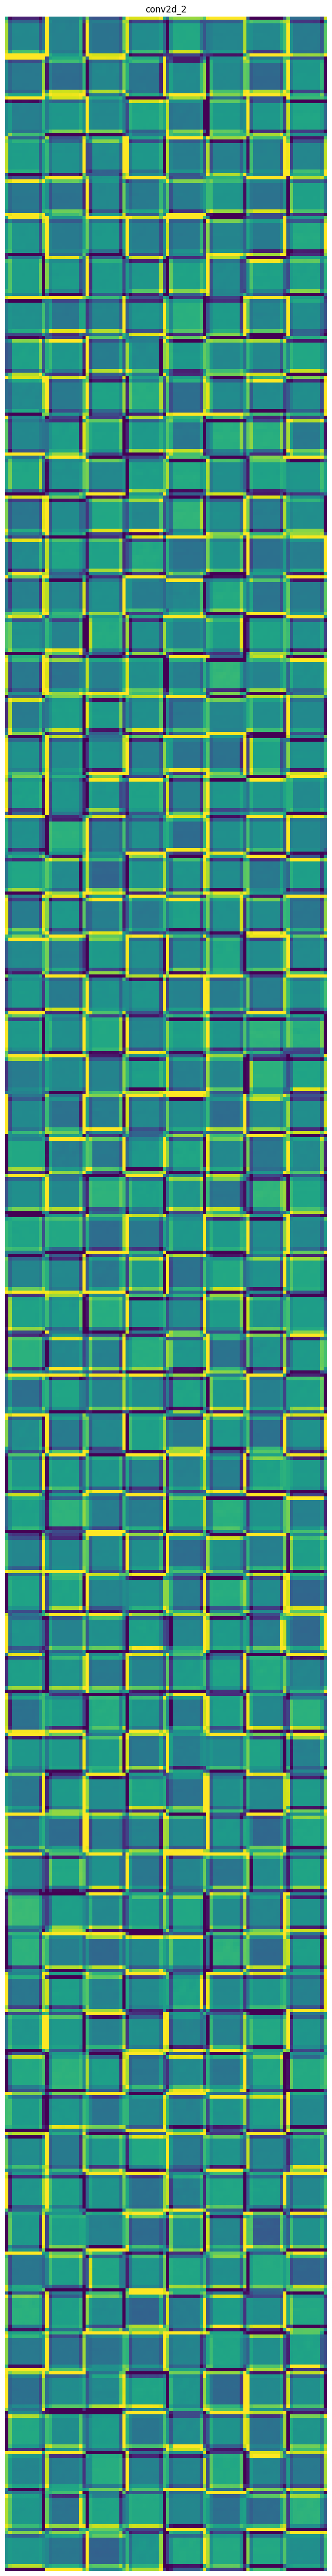


🔍 Visualizing layer: activation_2


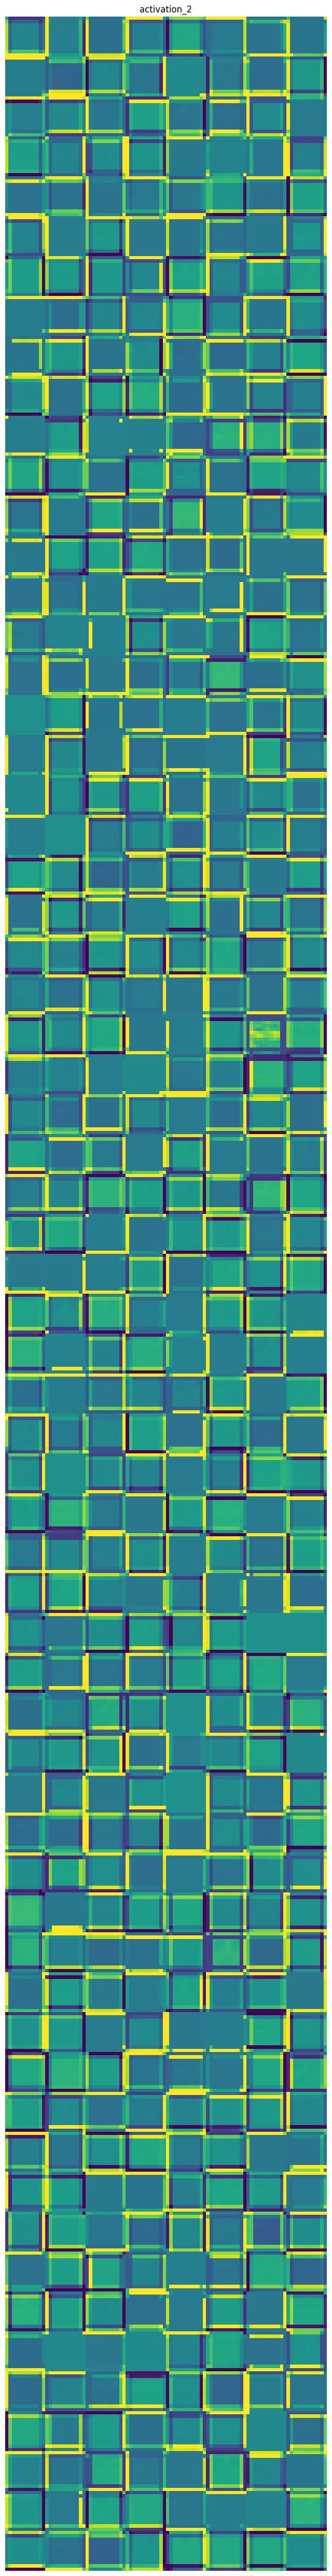


🔍 Visualizing layer: conv2d_3


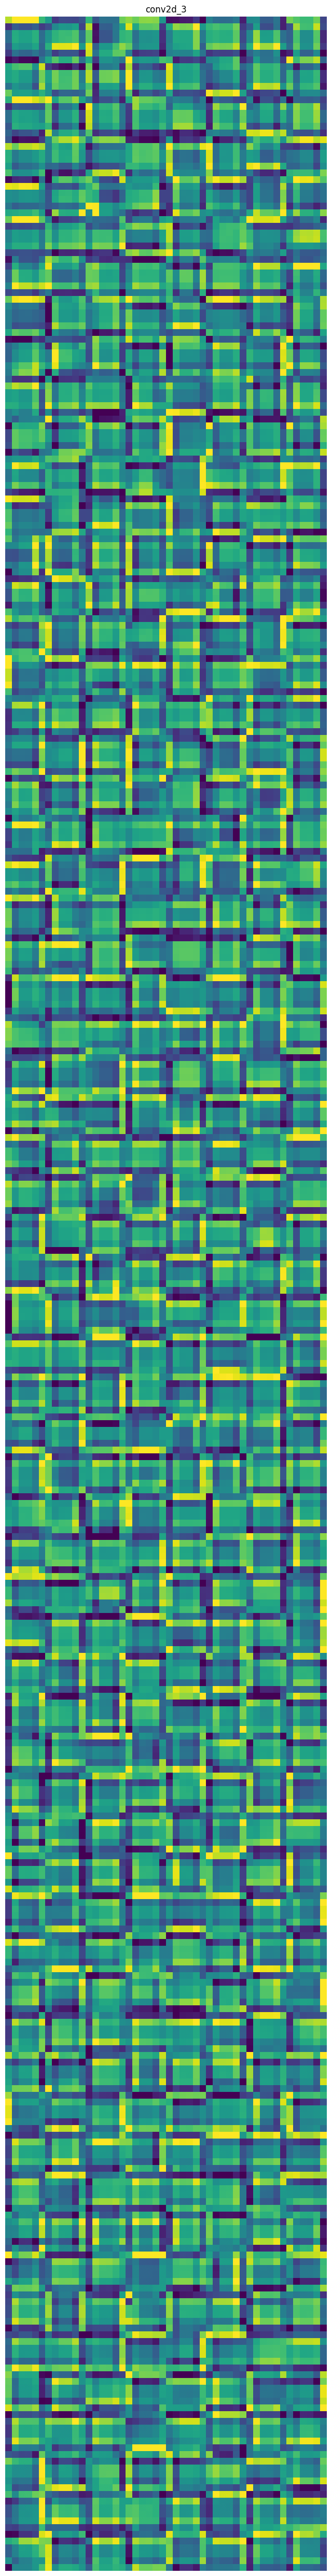


🔍 Visualizing layer: activation_3


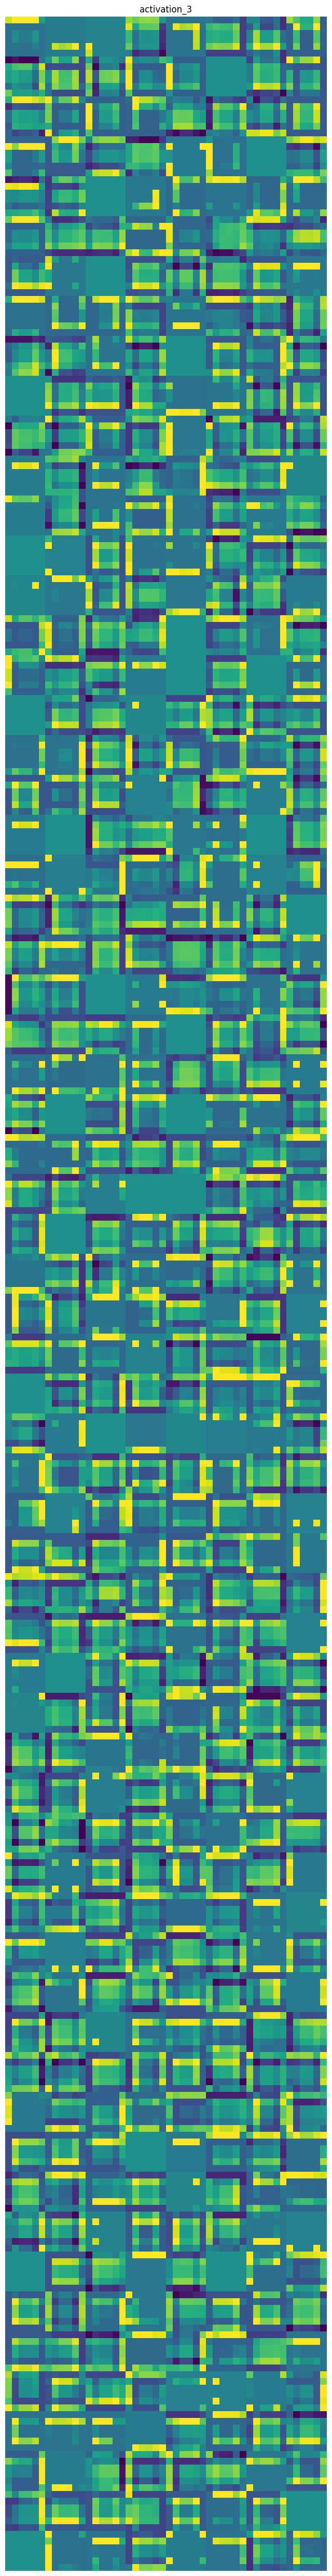


🔍 Visualizing layer: activation_4
⚠️ Skipping layer activation_4 (shape: (1, 256))

🔍 Visualizing layer: activation_5
⚠️ Skipping layer activation_5 (shape: (1, 512))


In [14]:
import os
image_path = os.path.join("test", "happy", "im3.png")
image = preprocess_image(image_path)
visualize_activations(model, image)